In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

sys.version_info(major=3, minor=11, micro=13, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.2
sklearn 1.6.1
torch 2.6.0+cu124
cuda:0


# 1. preprocessing data

## 数据加载

In [2]:
import unicodedata
import re


#因为西班牙语有一些是特殊字符，所以我们需要unicode转ascii，
# 这样值变小了，因为unicode太大
def unicode_to_ascii(s):
    #NFD是转换方法，把每一个字节拆开，Mn是重音，所以去除
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

#下面我们找个样本测试一下
# 加u代表对字符串进行unicode编码
en_sentence = u"May I borrow, this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))


May I borrow, this book?
¿Puedo tomar prestado este libro?


In [3]:
def preprocess_sentence(w):
    #变为小写，去掉多余的空格，变成小写，id少一些
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # eg: "he is a boy." => "he is a boy . "
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    #因为可能有多余空格，替换为一个空格，所以处理一下
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格，你可以保留一些标点符号
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)



    w = w.strip() #strip是去掉两边的空格

    return w

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))  #¿是占用两个字节的

may i borrow , this book ?
¿ puedo tomar prestado este libro ?
b'\xc2\xbf puedo tomar prestado este libro ?'


In [4]:
#划分训练集和测试集的一个方法
split_index1 = np.random.choice(a=["train", "test"], replace=True, p=[0.9, 0.1], size=100)
split_index1

array(['train', 'test', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'test', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'test', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'test', 'train', 'train', 'train', 'train', 'train',
       'train', 'test', 'train', 'test', 'train', 'train', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train'], dty

## Dataset

In [5]:
# 创建一个继承自torch.utils.data.Dataset的数据集类
import torch
from torch.utils.data import Dataset
import os


class TranslationDataset(Dataset):
    def __init__(self, path, num_examples=None, split=None):
        # 检查是否存在缓存文件
        cache_file_en = f"{split}_en_sentences.npy" if split else "all_en_sentences.npy"
        cache_file_sp = f"{split}_sp_sentences.npy" if split else "all_sp_sentences.npy"

        # 如果缓存文件存在，直接加载
        if os.path.exists(cache_file_en) and os.path.exists(cache_file_sp):
            print(f"从缓存文件加载{split}数据...")
            self.trg = np.load(cache_file_en)
            self.src = np.load(cache_file_sp)
        else:
            print(f"从{path}读取数据并创建{split}数据集...")
            # 读取文件
            lines = open(path, encoding="UTF-8").read().strip().split("\n")

            # 创建空列表存储英语和西班牙语句子对
            self.en_sentences = []
            self.sp_sentences = []

            # 生成训练集和测试集的索引,如果num_examples为None，则使用所有行，否则使用num_examples行
            total_examples = (
                len(lines) if num_examples is None else min(num_examples, len(lines))
            )
            split_index = np.random.choice(
                a=["train", "test"], replace=True, p=[0.9, 0.1], size=total_examples
            )

            # 遍历每一行，按tab分隔英语和西班牙语
            for i, line in enumerate(lines[:total_examples]):
                # 如果指定了split，则只保留对应的数据
                if split is not None and split_index[i] != split:
                    continue

                # 按tab分隔
                en, sp = line.split("\t")

                # 预处理句子
                en = preprocess_sentence(en)
                sp = preprocess_sentence(sp)

                # 添加到列表中
                self.en_sentences.append(en)
                self.sp_sentences.append(sp)

            # 转换为numpy数组
            self.trg = np.array(self.en_sentences)  # 英语
            self.src = np.array(self.sp_sentences)  # 西班牙语

            # 保存为numpy文件进行缓存
            np.save(cache_file_en, self.trg)
            np.save(cache_file_sp, self.src)

    def __len__(self):
        return len(self.trg)

    def __getitem__(self, idx):
        return self.src[idx], self.trg[idx]


# 从spa.txt创建数据集
train_dataset = TranslationDataset("spa.txt", split="train")
test_dataset = TranslationDataset("spa.txt", split="test")

从spa.txt读取数据并创建train数据集...
从spa.txt读取数据并创建test数据集...


In [6]:
print("source: {}\ntarget: {}".format(*train_dataset[-1]))

source: si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado .
target: if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo .


### Tokenizer

这里有两种处理方式，分别对应着 encoder 和 decoder 的 word embedding 是否共享，这里实现不共享的方案。

In [7]:
from collections import Counter
import numpy as np


# 构建英语和西班牙语的词典
def build_vocab(sentences, min_freq=1):
    # 初始化词典，包含特殊标记
    word2idx = {
        "[PAD]": 0,  # 填充 token
        "[BOS]": 1,  # begin of sentence
        "[UNK]": 2,  # 未知 token
        "[EOS]": 3,  # end of sentence
    }

    # 使用Counter统计词频
    counter = Counter()
    for sentence in sentences:
        counter.update(sentence.split())

    # 按词频排序并添加到词典中
    idx = len(word2idx)
    # 返回计数最高的前 n 个元素及其计数，若未指定 n 则返回所有元素
    for word, count in counter.most_common():
        if count >= min_freq:
            word2idx[word] = idx
            idx += 1

    return word2idx


# 构建英语和西班牙语词典
trg_word2idx = build_vocab(train_dataset.trg)  # 英语
src_word2idx = build_vocab(train_dataset.src)  # 西班牙语

# 创建反向映射（索引到词）
trg_idx2word = {idx: word for word, idx in trg_word2idx.items()}
src_idx2word = {idx: word for word, idx in src_word2idx.items()}

# 打印词典大小
print(f"英语词典大小: {len(trg_word2idx)}")
print(f"西班牙语词典大小: {len(src_word2idx)}")

英语词典大小: 12504
西班牙语词典大小: 23719


# Tokenizer

In [8]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx  # 词到索引的映射字典
        self.idx2word = idx2word  # 索引到词的映射字典
        self.max_length = max_length  # 序列的最大长度
        self.pad_idx = pad_idx  # 填充标记的索引
        self.bos_idx = bos_idx  # 句子开始标记的索引
        self.eos_idx = eos_idx  # 句子结束标记的索引
        self.unk_idx = unk_idx  # 未知词标记的索引

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """如果padding_first == True，则padding加载前面，否则加载后面
        return_mask: 是否返回mask(掩码），mask用于指示哪些是padding的，哪些是真实的token
        """
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))  # 计算实际需要的最大长度
        indices_list = []  # 初始化索引列表
        for text in text_list:  # 遍历每个文本
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]]  # 将文本中的词转换为索引，如果词不在词表中则使用unk_idx
            if add_bos:  # 如果需要添加句子开始标记
                indices = [self.bos_idx] + indices  # 在序列开头添加BOS标记
            if add_eos:  # 如果需要添加句子结束标记
                indices = indices + [self.eos_idx]  # 在序列末尾添加EOS标记
            if padding_first:  # 如果padding需要加在前面
                indices = [self.pad_idx] * (max_length - len(indices)) + indices  # 在序列前面添加padding
            else:  # 如果padding需要加在后面
                indices = indices + [self.pad_idx] * (max_length - len(indices))  # 在序列后面添加padding
            indices_list.append(indices)  # 将处理后的索引添加到列表中
        input_ids = torch.tensor(indices_list)  # 将索引列表转换为tensor
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64)  # 创建mask，1表示padding位置，0表示实际token位置
        return input_ids if not return_mask else (input_ids, masks)  # 根据return_mask参数决定返回值

    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        text_list = []  # 初始化文本列表
        for indices in indices_list:  # 遍历每个索引序列
            text = []  # 初始化当前文本
            for index in indices:  # 遍历序列中的每个索引
                word = self.idx2word.get(index, "[UNK]")  # 将索引转换为词，如果索引不在词表中则使用"[UNK]"
                if remove_bos and word == "[BOS]":  # 如果需要移除BOS标记且当前词是BOS
                    continue  # 跳过这个词
                if remove_eos and word == "[EOS]":  # 如果需要移除EOS标记且当前词是EOS
                    break  # 结束当前序列的处理
                if remove_pad and word == "[PAD]":  # 如果需要移除PAD标记且当前词是PAD
                    break  # 结束当前序列的处理
                text.append(word)  # 将词添加到当前文本中
            text_list.append(" ".join(text) if not split else text)  # 根据split参数决定返回连接后的字符串还是词列表
        return text_list  # 返回处理后的文本列表

# 两个相对于1个tokenizer的好处是embedding的参数量减少
src_tokenizer = Tokenizer(word2idx=src_word2idx, idx2word=src_idx2word)  # 创建源语言(西班牙语)的tokenizer
trg_tokenizer = Tokenizer(word2idx=trg_word2idx, idx2word=trg_idx2word)  # 创建目标语言(英语)的tokenizer

batch_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices,mask = trg_tokenizer.encode(batch_text, padding_first=False, add_bos=True, add_eos=True,return_mask=True)

print("batch_text"+'-'*10)
for raw in batch_text:
    print(raw)
print("mask"+'-'*10)
for m in mask:
    print(m)
print("indices"+'-'*10)
for index in indices:
    print(index)

batch_text----------
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
mask----------
tensor([0, 0, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1])
indices----------
tensor([   1, 1745,  309,    3,    0,    0,    0])
tensor([   1,    2, 2103,    2,   39,    2,    3])
tensor([  1,  23,  12,  10, 924,   3,   0])


# DataLoader

In [9]:
def collate_fn(batch):
    """
    数据批处理函数

    Args:
        batch: 批次数据
        src_tokenizer: 源语言tokenizer
        trg_tokenizer: 目标语言tokenizer
        device: 设备，如果指定则将tensor移至该设备

    Returns:
        包含编码后的tensor的字典
    """
    src_texts = [pair[0].split() for pair in batch] #取batch内第0列进行分词，赋给src_words
    trg_texts = [pair[1].split() for pair in batch] #取batch内第1列进行分词，赋给trg_words

    # 编码源语言输入
    encoder_inputs, encoder_inputs_mask = src_tokenizer.encode(
        src_texts,
        padding_first=True, #padding加在前面
        add_bos=True,
        add_eos=True,
        return_mask=True
    )

    # 编码目标语言输入（用于训练时的teacher forcing）
    decoder_inputs= trg_tokenizer.encode(
        trg_texts,
        padding_first=False, #padding加在后面
        add_bos=True,
        add_eos=False,
        return_mask=False
    )

    # 编码目标语言标签（用于计算损失）
    decoder_labels, decoder_labels_mask = trg_tokenizer.encode(
        trg_texts,
        padding_first=False,
        add_bos=False,
        add_eos=True,
        return_mask=True
    )

    result = {
        "encoder_inputs": encoder_inputs,
        "encoder_inputs_mask": encoder_inputs_mask,
        "decoder_inputs": decoder_inputs,
        "decoder_labels": decoder_labels,
        "decoder_labels_mask": decoder_labels_mask
    }

    # 如果指定了设备，将所有tensor移至该设备
    if device is not None:
        result = {k: v.to(device=device) for k, v in result.items()}

    return result





In [10]:
from torch.utils.data import DataLoader
sample_dl = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

#两次执行这个代码效果不一样，因为每次执行都会shuffle
for batch in sample_dl:
    for key, value in batch.items():
        print(key)
        print(value)
    break

encoder_inputs
tensor([[   0,    1,   17,    6,   72,   15,    7,    4,    3],
        [   1,   10, 3919,    7, 1753,  142, 2999,    4,    3]],
       device='cuda:0')
encoder_inputs_mask
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
decoder_inputs
tensor([[   1,    5,   46,   91,   14,  494,   71,    4,    0],
        [   1,    9, 2038,    6, 2008,  261,  373,   15,    4]],
       device='cuda:0')
decoder_labels
tensor([[   5,   46,   91,   14,  494,   71,    4,    3,    0],
        [   9, 2038,    6, 2008,  261,  373,   15,    4,    3]],
       device='cuda:0')
decoder_labels_mask
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


# 定义模型

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    """
    序列到序列模型的编码器部分
    """
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=1, dropout=0.0):
        """
        初始化编码器

        参数:
        - vocab_size: 源语言词汇表大小
        - embedding_dim: 词嵌入维度
        - hidden_size: 隐藏状态维度
        - num_layers: GRU层数
        - dropout: Dropout比率
        """
        super().__init__()

        # 词嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU层,batch_first=True表示输入的形状为[batch_size, seq_len]
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, src, src_mask=None, src_lengths=None):
        """
        前向传播

        参数:
        - src: 源语言序列 [batch_size, seq_len]
        - src_mask: 源语言序列的掩码 [batch_size, seq_len]
        - src_lengths: 源语言序列的实际长度 [batch_size]

        返回:
        - encoder_outputs: 编码器所有时间步的输出 [batch_size, seq_len, hidden_size]
        - hidden: 解码器初始隐藏状态 [num_layers, batch_size, hidden_size]
        """

        # 词嵌入
        embedded = self.dropout(self.embedding(src))  #[batch_size, seq_len] -> [batch_size, seq_len, embedding_dim]

        # 通过GRU
        #[batch_size, seq_len, embedding_dim]-> encoder_outputs [batch_size, seq_len, hidden_dim]
        #[batch_size, seq_len, embedding_dim]-> hidden [num_layers, batch_size, hidden_dim]
        encoder_outputs, hidden = self.gru(embedded)

        # 返回编码器所有时间步的输出和解码器初始隐藏状态
        return encoder_outputs, hidden


In [12]:
# 测试Encoder
import torch

# 创建测试参数
vocab_size = len(src_tokenizer.word2idx)
embedding_dim = 256
hidden_size = 512
num_layers = 2
dropout = 0.3
batch_size = 64
seq_len = 20

# 实例化Encoder
encoder = Encoder(vocab_size, embedding_dim, hidden_size, num_layers, dropout)

# 创建测试输入
src = torch.randint(0, vocab_size, (batch_size, seq_len))  # [batch_size, seq_len]

# 前向传播
encoder_outputs, hidden = encoder(src)

# 打印输出形状
print(f"源序列形状: {src.shape}")
print(f"编码器输出形状: {encoder_outputs.shape}")
print(f"隐藏状态形状: {hidden.shape}")

# 验证输出维度是否符合预期
assert encoder_outputs.shape == (batch_size, seq_len, hidden_size)
assert hidden.shape == (num_layers, batch_size, hidden_size)

print("Encoder测试通过!")


源序列形状: torch.Size([64, 20])
编码器输出形状: torch.Size([64, 20, 512])
隐藏状态形状: torch.Size([2, 64, 512])
Encoder测试通过!


# Bahdanau注意力

In [13]:
# 模拟 logits 和 mask
logits = torch.tensor([[1.0, 2.0, 3.0, 4.0]])
mask = torch.tensor([[1, 1, 0, 0]])  # 只让前两个位置有效

# 把无效位置设为 -inf
masked_logits = logits.masked_fill(mask == 1, float('-inf'))
masked_logits

tensor([[-inf, -inf, 3., 4.]])

In [14]:
class BahdanauAttention(nn.Module):
    """
    Bahdanau注意力机制

    参数:
        hidden_size: 隐藏状态的维度
        key_size: 键向量的维度（如果与隐藏状态不同）
        value_size: 值向量的维度（如果与隐藏状态不同）
    """
    def __init__(self, hidden_size, key_size=None):
        super().__init__()

        # 如果key_size和value_size未指定，则默认与hidden_size相同
        if key_size is None:
            key_size = hidden_size

        # 定义注意力层
        self.Wq = nn.Linear(hidden_size, hidden_size)
        self.Wk = nn.Linear(key_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, query, keys, values, attn_mask=None):
        """
        参数:
            query:decoder的隐藏状态 查询向量 [batch_size, hidden_size]
            keys: EO 键向量 [batch_size, src_len, key_size]
            values:EO  值向量 [batch_size, src_len, value_size]
            attn_mask: 注意力掩码 [batch_size, src_len]

        返回:
            context: 上下文向量 [batch_size, value_size]
            attention_weights: 注意力权重 [batch_size, src_len]
        """
        src_len = keys.size(1)

        # 将query从[batch_size, hidden_size]转换为[batch_size, 1, hidden_size]
        query = self.Wq(query).unsqueeze(1).repeat(1, src_len, 1)

        # 转换keys,shape=[batch_size, src_len, hidden_size]
        keys = self.Wk(keys)

        # 计算注意力分数
        energy = torch.tanh(keys+query)
        # [batch_size, src_len, hidden_size] -> [batch_size, src_len, 1] -> [batch_size, src_len]
        attention = self.V(energy).squeeze(2)

        # 应用注意力掩码（如果提供）
        if attn_mask is not None:
            attn_mask = attn_mask * -1e16
            attention += attn_mask #加上一个负无穷，让padding部分经过softmax后为0

        # 使用softmax归一化注意力权重  [batch_size, src_len]
        attention_weights = F.softmax(attention, dim=1)

        # 计算上下文向量,values是EO,shape=[batch_size, src_len, hidden_dim]
        context_vector = torch.mul(attention_weights.unsqueeze(-1), values).sum(dim=1) #对每一个词的score和对应的value做乘法，然后在seq_len维度上求和，得到context_vector
        # context_vector.shape = [batch size, hidden_dim]
        #attention_weights用于最后的画图
        return context_vector, attention_weights



Query shape: torch.Size([2, 8])
Keys shape: torch.Size([2, 4, 8])
Values shape: torch.Size([2, 4, 8])
Context vector shape: torch.Size([2, 8])
Attention weights shape: torch.Size([2, 4])

Attention weights:
tensor([[0.0000, 0.3361, 0.2892, 0.3747],
        [0.3570, 0.1988, 0.1800, 0.2642]], grad_fn=<SoftmaxBackward0>)


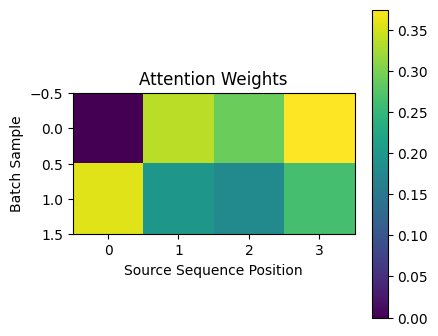

In [15]:
# 测试BahdanauAttention
def test_bahdanau_attention():
    # 设置参数
    batch_size = 2
    hidden_size = 8
    src_len = 4

    # 创建输入数据
    query = torch.randn(batch_size, hidden_size)  # Decoder的隐藏状态
    keys = torch.randn(batch_size, src_len, hidden_size)  # Encoder输出
    values = torch.randn(batch_size, src_len, hidden_size)  # 通常与keys相同

    # 创建注意力掩码，模拟序列填充的情况
    attn_mask = torch.zeros(batch_size, src_len)
    attn_mask[0, 0] = 1  # 假设第一个样本的最后一个token是padding
    # attn_mask[1, 2:] = 1  # 假设第二个样本的最后两个tokens是padding

    # 初始化Bahdanau注意力机制
    attention = BahdanauAttention(hidden_size, hidden_size)

    # 前向传播
    context, attn_weights = attention(query, keys, values, attn_mask)

    # 打印结果
    print(f"Query shape: {query.shape}")
    print(f"Keys shape: {keys.shape}")
    print(f"Values shape: {values.shape}")
    print(f"Context vector shape: {context.shape}")
    print(f"Attention weights shape: {attn_weights.shape}")

    # 验证注意力权重是否在掩码位置接近于0
    print("\nAttention weights:")
    print(attn_weights)

    # 可视化注意力权重
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(attn_weights.detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title('Attention Weights')
    plt.xlabel('Source Sequence Position')
    plt.ylabel('Batch Sample')

    return context, attn_weights

# 运行测试
context, attn_weights = test_bahdanau_attention()


# Decoder 解码器

In [16]:
class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=256,
        hidden_dim=1024,
        num_layers=1,
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size) #最后分类,词典大小是多少，就输出多少个分类
        self.dropout = nn.Dropout(0.6) #0.6可以调整的超参数
        self.attention = BahdanauAttention(hidden_dim) #注意力得到的context_vector

    def forward(self, decoder_input, hidden, encoder_outputs, attn_mask=None):
        """
        参数:
            decoder_input: 解码器的输入，形状为 [batch_size, 1]
            hidden: 解码器的隐藏状态，形状为 [batch_size, hidden_dim],第一次使用的是encoder的hidden
            encoder_outputs: 编码器的输出，形状为 [batch_size, sequence_length, hidden_dim]
            attn_mask: 注意力掩码，形状为 [batch_size, sequence_length],是encoder_inputs_mask

        返回:
            logits: 解码器的输出，形状为 [batch_size, 1, vocab_size]
            hidden: 解码器的隐藏状态，形状为 [batch_size, hidden_dim]
            attention_score: 注意力权重，形状为 [batch_size, sequence_length, 1]
        """
        #断言，确保输入的形状是正确的
        # decoder_input.shape = [batch size, 1]
        assert len(decoder_input.shape) == 2 and decoder_input.shape[-1] == 1, f"decoder_input.shape = {decoder_input.shape} is not valid"
        # hidden.shape = [num_layers, batch size, hidden_dim]，decoder_hidden,而第一次使用的是encoder的hidden
        assert len(hidden.shape) == 3, f"hidden.shape = {hidden.shape} is not valid"
        # encoder_outputs.shape = [batch size, sequence length, hidden_dim]
        assert len(encoder_outputs.shape) == 3, f"encoder_outputs.shape = {encoder_outputs.shape} is not valid"
        # context_vector.shape = [batch_size, hidden_dim]

        # 注意力机制
        context_vector, attention_score = self.attention(
            query=hidden[-1], keys=encoder_outputs, values=encoder_outputs, attn_mask=attn_mask)
        # decoder_input.shape = [batch size, 1]-->embeds.shape = [batch size, 1, embedding_dim]
        embeds = self.embedding(decoder_input)

        # context_vector.shape = [batch size, hidden_dim] -->unsqueeze(-2)增加维度 [batch size, 1, hidden_dim]
        embeds = torch.cat([context_vector.unsqueeze(-2), embeds], dim=-1)
        # 新的embeds.shape = [batch size, 1, embedding_dim + hidden_dim]
        seq_output, hidden = self.gru(embeds) #这里可以把hidden去掉对比一下最终的bleu指标
        # seq_output.shape = [batch size, 1, hidden_dim]
        logits = self.fc(self.dropout(seq_output))
        # logits.shape = [batch size, 1, vocab size]，attention_score = [batch size, sequence length, 1]
        return logits, hidden, attention_score



In [17]:
# 前向计算验证Decoder是否ok
batch_size = 2
seq_len = 5
hidden_dim = 32
vocab_size = 1000
embedding_dim = 64
num_layers = 1

# 创建模拟数据
decoder_input = torch.randint(0, vocab_size, (batch_size, 1))  # [batch_size, 1]
decoder_hidden = torch.randn(num_layers, batch_size, hidden_dim)  # [num_layers, batch_size, hidden_dim]
encoder_outputs = torch.randn(batch_size, seq_len, hidden_dim)  # [batch_size, seq_len, hidden_dim]
attn_mask = torch.ones(batch_size, seq_len)  # [batch_size, seq_len]

# 创建Decoder模型
decoder = Decoder(vocab_size, embedding_dim, hidden_dim)

# 前向计算
logits, hidden, attention_score = decoder(decoder_input, decoder_hidden, encoder_outputs, attn_mask)

# 打印输出形状
print(f"decoder_input.shape: {decoder_input.shape}")
print(f"decoder_hidden.shape: {decoder_hidden.shape}")
print(f"encoder_outputs.shape: {encoder_outputs.shape}")
print(f"logits.shape: {logits.shape}")
print(f"hidden.shape: {hidden.shape}")
print(f"attention_score.shape: {attention_score.shape}")


decoder_input.shape: torch.Size([2, 1])
decoder_hidden.shape: torch.Size([1, 2, 32])
encoder_outputs.shape: torch.Size([2, 5, 32])
logits.shape: torch.Size([2, 1, 1000])
hidden.shape: torch.Size([1, 2, 32])
attention_score.shape: torch.Size([2, 5])


# Sequence2Sequence

In [18]:
class Seq2Seq(nn.Module):
    def __init__(
        self,
        src_vocab_size, #输入词典大小
        trg_vocab_size, #输出词典大小
        encoder_embedding_dim=256,
        encoder_hidden_dim=1024, #encoder_hidden_dim和decoder_hidden_dim必须相同，是因为BahdanauAttention设计的
        encoder_num_layers=1,
        decoder_embedding_dim=256,
        decoder_hidden_dim=1024,
        decoder_num_layers=1,
        bos_idx=1,
        eos_idx=3,
        max_length=512,
        device=None,
        ):
        super().__init__()
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.max_length = max_length
        self.device = device
        self.encoder = Encoder(
            src_vocab_size,
            embedding_dim=encoder_embedding_dim,
            hidden_size=encoder_hidden_dim,
            num_layers=encoder_num_layers,
            )
        self.decoder = Decoder(
            trg_vocab_size,
            embedding_dim=decoder_embedding_dim,
            hidden_dim=decoder_hidden_dim,
            num_layers=decoder_num_layers,
            )

    def forward(self, src, decoder_input, src_mask=None, teacher_forcing_ratio=0.5):
        """
        训练时的前向传播

        Args:
            src: 源序列 [batch_size, src_len]
            tgt: 目标序列 [batch_size, tgt_len]
            src_mask: 源序列的mask [batch_size, src_len]
            teacher_forcing_ratio: 使用teacher forcing的概率

        Returns:
            outputs: 所有时间步的输出 [batch_size, tgt_len, vocab_size]
        """
        batch_size = src.shape[0]
        tgt_len = decoder_input.shape[1]

        # 编码器前向传播
        encoder_outputs, hidden = self.encoder(src)

        logits_list = []
        scores_list = []
        for t in range(tgt_len):
            # 解码器前向传播,output.shape = [batch_size, 1, vocab_size]
            #attention_scores.shape = [batch_size, src_len, 1]
            logits, hidden, attention_scores = self.decoder(decoder_input[:, t:t+1], hidden, encoder_outputs, src_mask)

            logits_list.append(logits)
            scores_list.append(attention_scores)

        # 返回输出和注意力分数
        #logits_list.shape (batch_size, tgt_len, vocab_size)
        #scores_list.shape (batch_size, src_len, tgt_len)
        return torch.cat(logits_list, dim=-2), torch.cat(scores_list, dim=-1)

    @torch.no_grad()
    def infer(self, src, src_mask=None):
        """
        推理时的前向传播

        Args:
            src: 源序列 [batch_size, src_len]
            src_mask: 源序列的mask [batch_size, src_len],一个样本mask没有用，多个样本mask有用

        Returns:
            outputs: 生成的序列 [batch_size, max_len]
            attention_scores: 注意力分数 [batch_size, src_len, max_len]
        """
        batch_size = src.shape[0]
        src_len = src.shape[1]

        # 编码器前向传播
        encoder_outputs, hidden = self.encoder(src)

        # 存储生成的序列
        outputs = torch.zeros(batch_size, self.max_length).long().to(self.device) #shape (bs, max_length)

        # 第一个解码器输入是特殊的开始符号 shape (bs,1)
        decoder_input = torch.tensor([[self.bos_idx]] * batch_size).to(self.device)

        # 记录每个序列是否已经生成了结束符号，shape (bs,)，做结束标记用，如果为True，则表示该序列已经生成了结束符号
        finished = torch.zeros(batch_size).bool().to(self.device)
        score_list = [] #为了画图，记录注意力分数
        for t in range(self.max_length):
            # 解码器前向传播,output.shape = [batch_size, 1, vocab_size]
            output, hidden, scores = self.decoder(decoder_input, hidden, encoder_outputs, src_mask)

            # 存储注意力分数 scores.shape = [batch_size, src_len, 1]
            score_list.append(scores)

            # 获取最可能的单词索引
            pred = output.argmax(dim=-1) #pred shape (bs,1)

            # 保存预测
            outputs[:, t] = pred.squeeze(1)

            # 如果所有序列都生成了结束符号，则提前结束
            finished = finished | (pred.squeeze(1) == self.eos_idx)
            if finished.all():#finished.all()是判断finished是否全为True
                break

            # 使用当前预测作为下一个输入
            decoder_input = pred

        return outputs, torch.cat(score_list,dim=0)


In [19]:
model = Seq2Seq(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx))
#做model的前向传播，看看输出的shape
encoder_inputs = torch.randint(0, 100, (2, 50)) #shape (bs, src_len) (2,50)
decoder_inputs = torch.randint(0, 100, (2, 60)) #shape (bs, tgt_len) (2,60)
attn_mask = torch.randint(0, 2, (2, 50)) #shape (bs, src_len) (2,50)
logits, scores = model(src=encoder_inputs, decoder_input=decoder_inputs, src_mask=attn_mask)
print(logits.shape)
print(scores.shape)

torch.Size([2, 60, 12504])
torch.Size([2, 3000])


In [20]:
# 计算模型的参数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 统计总参数量
total_params = count_parameters(model)
print(f"模型总参数量: {total_params:,}")

# 统计每个组件的参数量
encoder_params = count_parameters(model.encoder)
decoder_params = count_parameters(model.decoder)

print(f"编码器参数量: {encoder_params:,} ({encoder_params/total_params:.2%})")
print(f"解码器参数量: {decoder_params:,} ({decoder_params/total_params:.2%})")


模型总参数量: 35,212,248
编码器参数量: 10,010,368 (28.43%)
解码器参数量: 25,201,880 (71.57%)


In [21]:
# 创建具有4层的模型
model_4layers = Seq2Seq(
    src_vocab_size=len(src_word2idx),
    trg_vocab_size=len(trg_word2idx),
    encoder_num_layers=4,  # 编码器4层
    decoder_num_layers=4   # 解码器4层
)

# 统计总参数量
total_params_4layers = count_parameters(model_4layers)
print(f"4层模型总参数量: {total_params_4layers:,}")

# 统计每个组件的参数量
encoder_params_4layers = count_parameters(model_4layers.encoder)
decoder_params_4layers = count_parameters(model_4layers.decoder)

print(f"4层编码器参数量: {encoder_params_4layers:,} ({encoder_params_4layers/total_params_4layers:.2%})")
print(f"4层解码器参数量: {decoder_params_4layers:,} ({decoder_params_4layers/total_params_4layers:.2%})")

# 与默认层数模型比较
print(f"\n参数量增加: {total_params_4layers - total_params:,} ({total_params_4layers/total_params:.2f}倍)")


4层模型总参数量: 72,997,848
4层编码器参数量: 28,903,168 (39.59%)
4层解码器参数量: 44,094,680 (60.41%)

参数量增加: 37,785,600 (2.07倍)


# 损失函数

In [22]:
# 定义计算损失的函数，通过mask忽略特定位置
def cross_entropy_with_padding(logits, labels, padding_mask=None):
    # logits.shape = [batch size, sequence length, num of classes]
    # labels.shape = [batch size, sequence length]
    # padding_mask.shape = [batch size, sequence length] decoder_labels_mask
    bs, seq_len, nc = logits.shape
    loss = F.cross_entropy(logits.reshape(bs * seq_len, nc), labels.reshape(-1), reduce=False) #reduce=False表示不对batch求平均
    if padding_mask is None:#如果没有padding_mask，就直接求平均
        loss = loss.mean()
    else:
        # 如果提供了 padding_mask，则将padding填充部分的损失去除后计算有效损失的均值。首先，通过将 padding_mask reshape 成一维张量，并取 1 减去得到填充掩码。这样填充部分的掩码值变为 1，非填充部分变为 0。将损失张量与填充掩码相乘，这样填充部分的损失就会变为 0。然后，计算非填充部分的损失和（sum）以及非填充部分的掩码数量（sum）作为有效损失的均值计算。(因为上面我们设计的mask的token是0，所以这里是1-padding_mask)
        padding_mask = 1 - padding_mask.reshape(-1) #将padding_mask reshape成一维张量，mask部分为0，非mask部分为1
        loss = torch.mul(loss, padding_mask).sum() / padding_mask.sum()

    return loss



In [23]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [24]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -np.inf
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property #@property 装饰器将方法转换为属性，这样就可以通过实例.early_stop 来访问方法，而不是实例.early_stop()
    def early_stop(self):
        return self.counter >= self.patience


# 训练与评估

In [25]:
def evaluate(model, dataloader, loss_fct):
    """
    Evaluate the model on the validation/test set

    Args:
        model: the seq2seq model with attention
        dataloader: validation/test dataloader
        loss_fct: loss function

    Returns:
        float: average loss on the dataset
    """
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            # Unpack the batch
            encoder_inputs = batch["encoder_inputs"]
            encoder_inputs_mask = batch["encoder_inputs_mask"]
            decoder_inputs = batch["decoder_inputs"]
            decoder_labels = batch["decoder_labels"]
            decoder_labels_mask = batch["decoder_labels_mask"]

            # Forward pass
            outputs,_ = model(
                src=encoder_inputs,
                src_mask=encoder_inputs_mask,
                decoder_input=decoder_inputs
            )

            # Calculate loss
            loss = loss_fct(
                outputs,
                decoder_labels,
                decoder_labels_mask
            )

            # Update loss
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)

    model.train()
    return avg_loss


In [26]:
# 训练
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
):
    record_dict = {"train": [], "val": []}  # record_dict是字典，记录训练和验证的损失

    global_step = 1
    val_loss = 0
    model.train()  # 切换到训练模式
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for batch in train_loader:
                encoder_inputs = batch["encoder_inputs"]
                encoder_inputs_mask = batch["encoder_inputs_mask"]
                decoder_inputs = batch["decoder_inputs"]
                decoder_labels = batch["decoder_labels"]
                decoder_labels_mask = batch["decoder_labels_mask"]

                # 梯度清空
                optimizer.zero_grad()

                # 前向计算
                logits, _ = model(
                    src=encoder_inputs,
                    src_mask=encoder_inputs_mask,
                    decoder_input=decoder_inputs,
                )
                loss = loss_fct(
                    logits, decoder_labels, decoder_labels_mask
                )

                # 梯度回传
                loss.backward()

                # 调整优化器，包括学习率的变动等
                optimizer.step()

                loss = loss.cpu().item()
                # record
                record_dict["train"].append({"loss": loss, "step": global_step})

                # evaluating
                if global_step % eval_step == 0:
                    val_loss = evaluate(model, val_loader, loss_fct) #evaluate是计算验证集的损失
                    record_dict["val"].append({"loss": val_loss, "step": global_step})


                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(
                            global_step, model.state_dict(), metric=-val_loss
                        )

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:#early_stop_callback.early_stop是True，则早停
                            print(
                                f"Early stop at epoch {epoch_id} / global_step {global_step}"
                            )
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix(
                    {"epoch": epoch_id,'global_step': global_step, "loss": loss, "val_loss": val_loss}
                )  # 更新进度条

    return record_dict


epoch = 20
batch_size = 64

model = Seq2Seq(
    src_vocab_size=len(src_word2idx),
    trg_vocab_size=len(trg_word2idx),
    encoder_num_layers=1,
    decoder_num_layers=1,
)

# 为训练和验证数据创建DataLoader
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


# 1. 定义损失函数 采用交叉熵损失
loss_fct = cross_entropy_with_padding
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# 3. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(
    f"checkpoints", save_step=200, save_best_only=True
)
# 4. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)

In [27]:
record = training(
    model,
    train_dl,
    test_dl,
    epoch,
    loss_fct,
    optimizer,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=200
    )

  0%|          | 0/33520 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Early stop at epoch 9 / global_step 16000


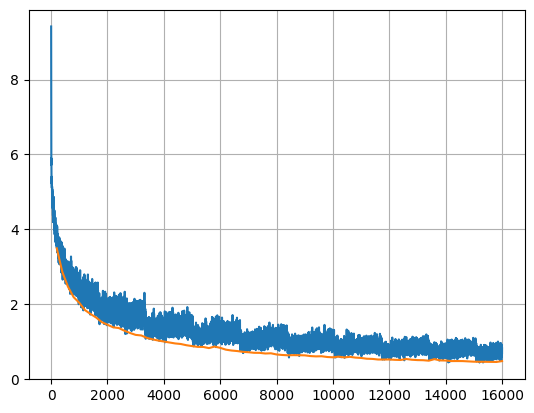

In [28]:
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.show()

['it', 's', 'fine', 'today', '.', '[EOS]']
torch.Size([6, 7])
6
7
(6, 7)


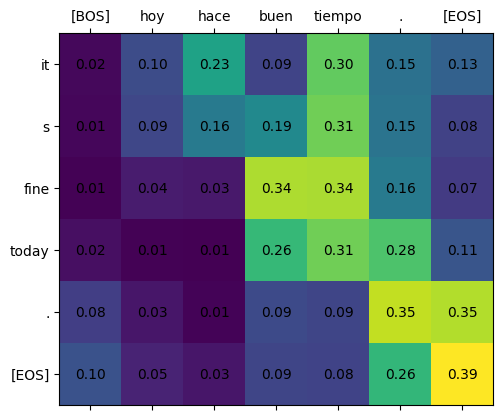

'it s fine today .'

In [29]:
# load checkpoints,如何上线,本地使用
model = Seq2Seq(len(src_word2idx), len(trg_word2idx))
model.load_state_dict(torch.load(f"checkpoints/best.ckpt", weights_only=True,map_location="cpu"))

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        self.model = model
        self.model.eval() # 切换到验证模式
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def draw_attention_map(self, scores, src_words_list, trg_words_list):
        """绘制注意力热力图

        Args:
            - scores (numpy.ndarray): shape = [source sequence length, target sequence length]
        """
        plt.matshow(scores, cmap='viridis') # 注意力矩阵,显示注意力分数值
        # 获取当前的轴
        ax = plt.gca()

        # 设置热图中每个单元格的分数的文本
        for i in range(scores.shape[0]): #shape[0]是src_len
            for j in range(scores.shape[1]): #shape[1]是target_len
                ax.text(j, i, f'{scores[i, j]:.2f}',  # 格式化数字显示
                               ha='center', va='center', color='k')

        # 设置x轴和y轴的刻度，src_words_list是源语言的单词列表，trg_words_list是目标语言的单词列表
        print(len(trg_words_list))
        print(len(src_words_list))
        print(scores.shape)
        plt.xticks(range(scores.shape[1]), src_words_list)
        plt.yticks(range(scores.shape[0]), trg_words_list)
        plt.show()

    def __call__(self, sentence):
        sentence = preprocess_sentence(sentence) # 预处理句子，标点符号处理等
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,
            add_bos=True,
            add_eos=True,
            return_mask=True,
            ) # 对输入进行编码，并返回encode_piadding_mask
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64) # 转换成tensor

        preds, scores = model.infer(src=encoder_input, src_mask=attn_mask) #预测
        # print(preds)
        # print(scores)
        trg_sentence = self.trg_tokenizer.decode(preds.numpy(), split=True, remove_eos=False)[0] #通过tokenizer转换成文字
        print(trg_sentence)
        src_decoded = self.src_tokenizer.decode(
            encoder_input.tolist(),
            split=True,
            remove_bos=False,
            remove_eos=False
            )[0] #对输入编码id进行解码，转换成文字,为了画图
        print(scores.shape)
        self.draw_attention_map(
            scores.numpy(),
            src_decoded, # 注意力图的源句子
            trg_sentence # 注意力图的目标句子
            )
        return " ".join(trg_sentence[:-1])

translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)
translator('Hoy hace buen tiempo.')



['it', 's', 'been', 'very', 'cold', 'here', '.', '[EOS]']
torch.Size([8, 7])
8
7
(8, 7)


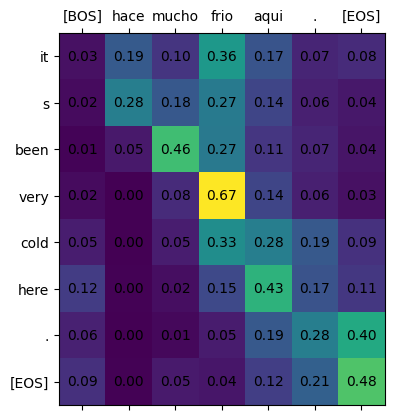

'it s been very cold here .'

In [30]:
translator('hace mucho frio aqui .')

In [31]:
!pip install nltk

In [42]:
model = Seq2Seq(len(src_word2idx), len(trg_word2idx))
model.load_state_dict(torch.load(f"./checkpoints/best.ckpt", map_location="cpu"))

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        self.model = model
        self.model.eval() # 切换到验证模式
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def __call__(self, sentence):
        sentence = preprocess_sentence(sentence) # 预处理句子，标点符号处理等
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,
            add_bos=True,
            add_eos=True,
            return_mask=True,
            ) # 对输入进行编码，并返回encode_piadding_mask
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64) # 转换成tensor

        preds, scores = model.infer(src=encoder_input, src_mask=attn_mask) #预测

        trg_sentence = self.trg_tokenizer.decode(preds.numpy(), split=True, remove_eos=False)[0] #通过tokenizer转换成文字
        # print(trg_sentence)
        return " ".join(trg_sentence[:-1])

from nltk.translate.bleu_score import sentence_bleu

def evaluate_bleu_on_test_set(test_data, translator):
    """
    在测试集上计算平均 BLEU 分数。
    :param test_data: 测试集数据，格式为 [(src_sentence, [ref_translation1, ref_translation2, ...]), ...]
    :param translator: 翻译器对象（Translator 类的实例）
    :return: 平均 BLEU 分数
    """
    total_bleu = 0.0
    num_samples = len(test_data)
    i=0
    for src_sentence, ref_translations in test_data:
        # 使用翻译器生成翻译结果
        candidate_translation = translator(src_sentence)
        # print(candidate_translation)
        # 计算 BLEU 分数
        bleu_score = sentence_bleu([ref_translations.split()], candidate_translation.split(),weights=(1, 0, 0, 0))
        total_bleu += bleu_score

        # 打印当前句子的 BLEU 分数（可选）
        # print(f"Source: {src_sentence}")
        # print(f"Reference: {ref_translations}")
        # print(f"Candidate: {candidate_translation}")
        # print(f"BLEU: {bleu_score:.4f}")
        # print("-" * 50)
        # i+=1
        # if i>10:
        #   break
    # 计算平均 BLEU 分数
    avg_bleu = total_bleu / num_samples
    return avg_bleu
translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)
evaluate_bleu_on_test_set(test_dataset, translator)

0.8199116127533412